In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [160]:
a = np.array([1, 2, 3, 4, 5])
b = np.array([0.1, 0.9, 0.8, 0.4, 0.5])

sf = np.array([[[0.5, 0.1, 0.05],
                [0.6, 0.1, 0.05],
                [0.7, 0.1, 0.05],
                [0.8, 0.1, 0.05],
                [0.9, 0.1, 0.05]],
               [[0.5, 0.2, 0.0],
                [0.6, 0.2, 0.0],
                [0.7, 0.2, 0.0],
                [0.8, 0.2, 0.0],
                [0.9, 0.2, 0.0]]])

# sf = np.array([[[0.5],
#                 [0.6],
#                 [0.7],
#                 [0.8],
#                 [0.9],
#                [[0.1],
#                 [0.2],
#                 [0.3],
#                 [0.4],
#                 [0.5]]]])

sf = np.array([[0.5, 0.6, 0.7, 0.8, 0.9],
               [0.1, 0.2, 0.3, 0.4, 0.5]])

weights = np.vstack([a, b]).T
print(sf.shape, weights.shape)
np.sum((sf.T*weights).T, axis=0) / np.sum(weights, axis=1).reshape(-1, 1)

(2, 5) (5, 2)


array([[0.46363636, 1.25454545, 2.12727273, 3.05454545, 4.31818182],
       [0.17586207, 0.47586207, 0.80689655, 1.15862069, 1.63793103],
       [0.13421053, 0.36315789, 0.61578947, 0.88421053, 1.25      ],
       [0.11590909, 0.31363636, 0.53181818, 0.76363636, 1.07954545],
       [0.09272727, 0.25090909, 0.42545455, 0.61090909, 0.86363636]])

In [150]:
np.mean(weights, axis=0)

array([3.  , 0.54])

In [156]:
np.sum((sf.T*weights).T, axis=0) / np.sum(weights, axis=1).reshape(-1, 1)

array([[0.5       , 0.10909091, 0.04545455],
       [0.6       , 0.13103448, 0.03448276],
       [0.7       , 0.12105263, 0.03947368],
       [0.8       , 0.10909091, 0.04545455],
       [0.9       , 0.10909091, 0.04545455]])

In [118]:
np.dot(sf.T, weights.T).shape

(3, 5, 5)

In [122]:
sf.T.shape

(3, 5, 2)

In [121]:
(weights @ sf)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 2)

In [141]:
np.tensordot(weights.T, sf.T, axes=0).shape

(2, 5, 3, 5, 2)

In [210]:
from survivors.tree import CRAID

class IBSCRAID(CRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ibs_leaf = None
        
    def set_ibs_by_leaf(self, X, y):
        numbs = self.predict(X, target="numb").astype("int")
        sf = self.predict_at_times(X, self.bins, mode="surv")
        ibs_v = metr.ibs(y, y, sf, self.bins, axis=0)

        counts = np.bincount(numbs)
        self.ibs_leaf = np.bincount(numbs, weights=ibs_v)
        self.ibs_leaf[counts>0]/=counts[counts>0]
        self.ibs_mean = np.mean(ibs_v)
    
    def get_ibs_by_leaf(self, X, divide=False):
        numbs = self.predict(X, target="numb").astype("int")
        if divide:
            return self.ibs_leaf[numbs] / self.ibs_mean
        return self.ibs_leaf[numbs]
    
    def fit(self, X, y):
        super().fit(X, y)
        self.set_ibs_by_leaf(X, y)

In [378]:
a = np.array([[1, 0.5, 0.3],
          [2, 0.8, 0.1],
          [3, 0.2, 0.9]])
(a - np.array([0, 1, 2])) / np.array([1, 2, 4])

array([[ 1.   , -0.25 , -0.425],
       [ 2.   , -0.1  , -0.475],
       [ 3.   , -0.4  , -0.275]])

In [767]:
from survivors.ensemble import BoostingCRAID
from scipy.stats import norm

class IBSBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSBoostingCRAID"
    
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)
        
        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y
        
        self.weights = np.zeros(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_weights = []
        self.ibs_means = []
        self.ibs_stds = []
        self.update_params()
        
        for i in range(self.n_estimators):
            if self.with_arc:
                prob_weights = arc_x4(self.weights)
            else:
                prob_weights = self.weights
            if i == 0:
                self.ibs_means.append(0.0)
                self.ibs_stds.append(1.0)
                prob_weights = np.ones(self.weights.shape)*0.5
            else:
                self.ibs_means.append(np.mean(self.weights))
                self.ibs_stds.append(np.std(self.weights))
            # wei = (self.weights - self.ibs_means[-1]) / self.ibs_stds[-1]
#             prob_weights = norm.cdf(wei)
#             plt.hist(wei)
#             plt.hist(wei[self.y_train["cens"]])
#             plt.show()
            # prob_weights = self.weights
            
            x_sub = self.X_train.sample(n=self.size_sample, weights=prob_weights,  # self.weights
                                        replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print("UNIQUE:", np.unique(x_sub.index).shape[0])
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = prob_weights[x_sub['ind_start']]  # self.weights

            model = IBSCRAID(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)
            
            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)
            self.ens_metr[i] = self.score_oob()
        
        if self.tolerance:
            self.tolerance_find_best()
        print('fitted:', len(self.models), 'models.')
    
    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = None
        if self.aggreg_func == "obs_wei":
            weights = [np.zeros(x_test.shape[0])]
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))
            if self.aggreg_func == "obs_wei":
                weights.append(self.models[i].get_ibs_by_leaf(x_test))
                
        res = np.array(res)
        if self.aggreg_func == "obs_wei":
            weights = np.vstack(weights[:-1]).T
            weights = np.cumsum(weights, axis=1)
            wei = (weights - np.array(self.ibs_means)) / np.array(self.ibs_stds)
            weights = norm.cdf(wei)
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res
    
    def select_model(self, start, end):
        self.ibs_means = self.ibs_means[start:end]
        self.ibs_stds = self.ibs_stds[start:end]
        super().select_model(start, end)
    
    def predict_sf_by_hazard(self, x_test, bins, aggreg=True):
        hf = self.predict_at_times(x_test, bins, aggreg=aggreg, mode="hazard")
        return np.exp(-1*hf)
    
    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        if mode=="surv":
            return self.predict_sf_by_hazard(x_test, bins, aggreg=aggreg)
        res = []
        weights = None
        if self.aggreg_func == "obs_wei":
            weights = [np.zeros(x_test.shape[0])]
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode)[np.newaxis, :])
            if self.aggreg_func == "obs_wei":
                weights.append(self.models[i].get_ibs_by_leaf(x_test))
                
        res = np.vstack(res)
        if self.aggreg_func == "obs_wei":
            weights = np.vstack(weights[:-1]).T
            weights = np.cumsum(weights, axis=1)
            wei = (weights - np.array(self.ibs_means)) / np.array(self.ibs_stds)
            weights = norm.cdf(wei)
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res
    
    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        
#         self.models.append(model)
#         self.bettas.append(1)
        
        pred_tree = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        wei = metr.ibs(self.y_train, y_sub, pred_tree, self.bins, axis=0)
        betta = np.mean(wei)

#         pred_tree = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
#         wei = metr.ibs(self.y_train, y_sub, pred_tree, self.bins, axis=0)
#         betta = np.mean(wei)
        
#         self.models = self.models[:-1]
#         self.bettas = self.bettas[:-1]
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights + wei_i
        else:
            self.weights[index] = (self.weights[index] + wei_i)
        # self.weights = (self.weights - self.weights.min())
        # self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        if self.aggreg_func == 'moda':
            res = np.median(x > 0.5, axis=0)
            return res
        if self.aggreg_func == 'complex':
            #a = np.max(x, axis=0)
            b = np.min(x, axis=0)
            res = np.mean(x, axis=0)
            #res[a == 1] = 1
            res[res < 0.01] = 0
            return res
        elif self.aggreg_func == 'softmax':
            inv_wei = np.exp(np.array(self.bettas))
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        elif self.aggreg_func == 'wei':
            inv_wei = 1/np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        elif self.aggreg_func == "obs_wei":
            wei_s = np.sum(wei, axis=1)
            if len(x.shape) > 2:
                wei_s = wei_s.reshape(-1, 1)
            return np.sum((x.T*wei).T, axis=0) / wei_s
            #return (wei @ x) / np.sum(wei, axis=1).reshape(-1, 1)
        return np.mean(x, axis=0)


In [768]:
from survivors.experiments.grid import generate_sample

X, y, features, categ, sch_nan = ds.load_onk_dataset()

for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
    pass

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


DIAG {'C20': 0, 'C50.4': 1, 'C61': 2}


In [775]:
# proboost_params = {'balance': None, 
#                    "with_arc": False,
#                    'aggreg_func': "obs_wei", 'all_weight': True, 'categ': ['Диагноз'], 
#                    'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'ibs', 
#                    'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 5, 
#                    'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.7}

proboost_params = {
 'balance': None, 
 "with_arc": False,
 'aggreg_func': 'obs_wei', 'all_weight': True, 'categ': ['Диагноз'], 
 'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'conc', 
 'leaf_model': 'wei_survive', 'max_features': 0.7, 'min_samples_leaf': 10, 
 'n_estimators': 30, 'n_jobs': 2, 'size_sample': 0.7
}

start_time = time.time()
proboost = IBSBoostingCRAID(**proboost_params)
proboost.fit(X_tr, y_tr)

print(time.time() - start_time)

UNIQUE: 1140
UNIQUE: 364
UNIQUE: 549
UNIQUE: 570
UNIQUE: 563
UNIQUE: 577
UNIQUE: 593
UNIQUE: 586
UNIQUE: 567
UNIQUE: 590
UNIQUE: 568
UNIQUE: 603
UNIQUE: 589
UNIQUE: 606
UNIQUE: 606
UNIQUE: 586
UNIQUE: 612
UNIQUE: 604
UNIQUE: 608
UNIQUE: 606
UNIQUE: 591
UNIQUE: 592
UNIQUE: 598
UNIQUE: 632
UNIQUE: 615
UNIQUE: 584
UNIQUE: 605
UNIQUE: 611
UNIQUE: 584
UNIQUE: 593
[0.7832 0.794  0.8173 0.8117 0.811  0.8187 0.8218 0.8206 0.8181 0.8219
 0.8249 0.8337 0.8378 0.8377 0.8372 0.8375 0.8387 0.838  0.8388 0.8391
 0.839  0.8417 0.8412 0.8424 0.843  0.8446 0.8449 0.8444 0.8438 0.8443]
fitted: 27 models.
80.94683694839478


Prior distribution: [1913  351]


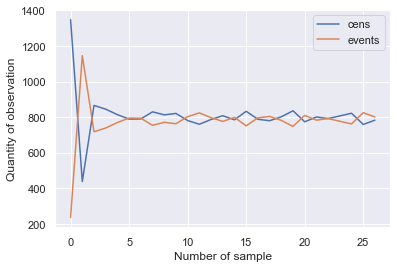

In [776]:
print("Prior distribution:", np.bincount(y_tr["cens"]))
n_cens = []
n_events = []
for i in range(len(proboost.models)):
    distr = np.bincount(proboost.models[i].nodes[0].leaf_model.predict_list_feature(feature_name="cens"))
    n_cens.append(distr[0])
    n_events.append(distr[1])

plt.plot(n_cens, label="cens")
plt.plot(n_events, label="events")
plt.legend()
plt.ylabel("Quantity of observation")
plt.xlabel("Number of sample")
plt.show()

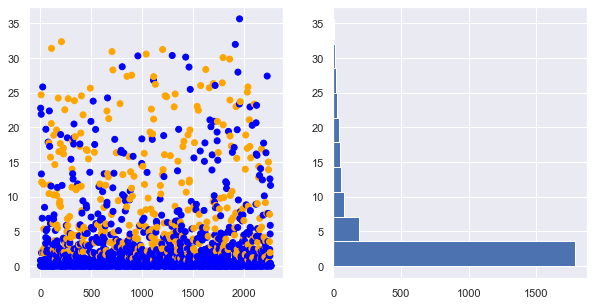

In [777]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
axes[0].scatter(np.arange(proboost.weights.shape[0]), 
                proboost.weights,
                c = np.where(proboost.y_train["cens"], "orange", "blue"))
axes[1].hist(proboost.weights, orientation="horizontal")
plt.show()

In [778]:
tr_pred_surv_proboost = proboost.predict_at_times(X_tr, bins=bins, mode="surv")

pred_surv_proboost = proboost.predict_at_times(X_HO, bins=bins, mode="surv")
pred_time_proboost = proboost.predict(X_HO, target=cnt.TIME_NAME)
pred_haz_proboost = proboost.predict_at_times(X_HO, bins=bins, mode="hazard")

In [779]:
print("TRAIN PR:", metr.ibs(y_tr, y_tr, tr_pred_surv_proboost, bins, axis=-1))
print("TRAIN EVENT PR:", metr.ibs(y_tr, y_tr[y_tr["cens"]], tr_pred_surv_proboost[y_tr["cens"]], bins, axis=-1))
print("TRAIN CENS PR:", metr.ibs(y_tr, y_tr[~y_tr["cens"]], tr_pred_surv_proboost[~y_tr["cens"]], bins, axis=-1))
print("TRAIN WEI=0 PR:", metr.ibs(y_tr, y_tr[np.where(proboost.weights<np.mean(proboost.weights))], 
                                  tr_pred_surv_proboost[np.where(proboost.weights<np.mean(proboost.weights))], bins, axis=-1))
print("TRAIN WEI=0 PR:", metr.ibs(y_tr, y_tr[np.where(proboost.weights>np.mean(proboost.weights))], 
                                  tr_pred_surv_proboost[np.where(proboost.weights>np.mean(proboost.weights))], bins, axis=-1))
print()
print("TEST PR:", metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=-1))
print("TEST EVENT PR:", metr.ibs(y_tr, y_HO[y_HO["cens"]], pred_surv_proboost[y_HO["cens"]], bins, axis=-1))
print("TEST CENS PR:", metr.ibs(y_tr, y_HO[~y_HO["cens"]], pred_surv_proboost[~y_HO["cens"]], bins, axis=-1))

TRAIN PR: 0.06119807700775853
TRAIN EVENT PR: 0.2155905738349956
TRAIN CENS PR: 0.03286991893856867
TRAIN WEI=0 PR: 0.008645800069564974
TRAIN WEI=0 PR: 0.22775879268111235

TEST PR: 0.11718806231350407
TEST EVENT PR: 0.4356136830983036
TEST CENS PR: 0.05877063665521105


In [794]:
y_t = y_HO[y_HO["cens"]]
test_ibs = metr.ibs(y_tr, y_t, pred_surv_proboost[y_HO["cens"]], bins, axis=0)

srt_idx = np.argsort(test_ibs)[::-1]
print(test_ibs[srt_idx][:10])
print(y_t[srt_idx][:10])
print(pred_surv_proboost[y_HO["cens"]][srt_idx][:10])

[1.79298024 1.78996611 1.64164624 1.53702385 1.45642066 1.43333997
 1.31778789 1.25867699 1.17799562 1.14974275]
[( True, 612.) ( True, 471.) ( True, 707.) ( True, 301.) ( True, 220.)
 ( True, 621.) ( True, 705.) ( True, 387.) ( True, 752.) ( True, 579.)]
[[1.         1.         1.         ... 0.71324166 0.71324166 0.65014585]
 [1.         1.         1.         ... 0.66695078 0.66695078 0.65374013]
 [1.         1.         1.         ... 0.34719671 0.34719671 0.34549994]
 ...
 [1.         1.         1.         ... 0.51961412 0.51961412 0.50558311]
 [1.         1.         1.         ... 0.55593309 0.55593309 0.55593309]
 [1.         1.         1.         ... 0.54790666 0.54790666 0.50160675]]


In [783]:
test_ibs[srt_idx]

array([0.        , 0.        , 0.        , ..., 2.02517762, 2.53568889,
       2.87518148])

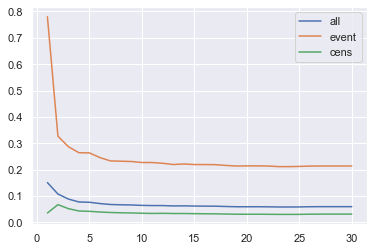

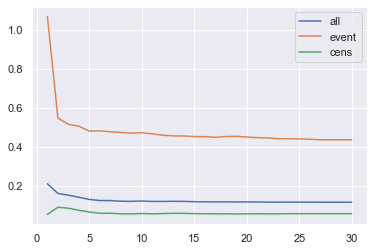

In [774]:
import copy

tr_all = []
tr_event = []
tr_cens = []

tst_all = []
tst_event = []
tst_cens = []

procopy = copy.deepcopy(proboost)
x = list(range(30, 0, -1))
for i in x:
    procopy.select_model(0, i)
    tr_pred = procopy.predict_at_times(X_tr, bins=bins, mode="surv")
    tst_pred = procopy.predict_at_times(X_HO, bins=bins, mode="surv")
    
    tr_all.append(metr.ibs(y_tr, y_tr, tr_pred, bins, axis=-1))
    tr_event.append(metr.ibs(y_tr, y_tr[y_tr["cens"]], tr_pred[y_tr["cens"]], bins, axis=-1))
    tr_cens.append(metr.ibs(y_tr, y_tr[~y_tr["cens"]], tr_pred[~y_tr["cens"]], bins, axis=-1))
    
    tst_all.append(metr.ibs(y_tr, y_HO, tst_pred, bins, axis=-1))
    tst_event.append(metr.ibs(y_tr, y_HO[y_HO["cens"]], tst_pred[y_HO["cens"]], bins, axis=-1))
    tst_cens.append(metr.ibs(y_tr, y_HO[~y_HO["cens"]], tst_pred[~y_HO["cens"]], bins, axis=-1))

plt.plot(x, tr_all, label="all")
plt.plot(x, tr_event, label="event")
plt.plot(x, tr_cens, label="cens")
plt.legend()
plt.show()
plt.plot(x, tst_all, label="all")
plt.plot(x, tst_event, label="event")
plt.plot(x, tst_cens, label="cens")
plt.legend()
plt.show()

In [ ]:
proboost.ibs_means

In [605]:
pred_time_proboost

array([ 20.61344266,  97.325549  , 449.3023549 , ...,  14.23570456,
        42.60921466,  84.91567243])

In [606]:
y_HO["time"]

array([  1.,   7., 357., ...,   2.,  14.,  44.])

In [611]:
res = []
weights = None
if proboost.aggreg_func == "obs_wei":
    weights = [np.zeros(X_HO.shape[0])]
for i in range(len(proboost.models)):
    res.append(proboost.models[i].predict(X_HO, target=cnt.TIME_NAME))
    if proboost.aggreg_func == "obs_wei":
        weights.append(proboost.models[i].get_ibs_by_leaf(X_HO))

res = np.array(res)
if proboost.aggreg_func == "obs_wei":
    weights = np.vstack(weights[:-1]).T
    weights = np.cumsum(weights, axis=1)
    weights = norm.cdf((weights - np.array(proboost.ibs_means)) / np.array(proboost.ibs_stds))

In [757]:
print(np.mean(proboost.weights[proboost.y_train["cens"]]))
print(np.mean(proboost.weights[~proboost.y_train["cens"]]))

9.311282092007119
1.7253787145420514


In [617]:
weights[1]

array([0.5       , 0.65882212, 0.75576912, 0.67123547, 0.66340646,
       0.56999353, 0.4820908 , 0.43119368, 0.39712532, 0.37137517,
       0.3804177 , 0.39086582, 0.46635157, 0.43576438, 0.41004133,
       0.42703959, 0.50086209, 0.51558803, 0.55835329, 0.52395362,
       0.49195177, 0.47727851, 0.4593069 , 0.43744934, 0.42408918,
       0.41439572, 0.40111487, 0.38275273, 0.39157805, 0.37727791])

In [613]:
res[:, 1]

array([ 88.5689621 , 101.        ,  94.26316071, 106.09889984,
        76.57142639, 141.1000061 ,  67.63636017,  51.80625153,
        53.77777863,  51.8571434 , 115.36842346,  85.1818161 ,
        48.16666794,  49.        , 114.69999695, 117.83333588,
        79.33333588,  89.83333588,  85.25      , 203.66667175,
        53.        ,  95.85713959, 131.75      , 148.1000061 ,
        65.        , 104.44444275, 200.83332825,  72.875     ,
       164.5       ,  49.57143021])

In [614]:
np.sum((res.T*1/weights).T, axis=0) / np.sum(1/weights, axis=1)

array([ 20.25475238,  96.44154524, 451.50193452, ...,  14.86393937,
        39.92787486,  84.87878912])

In [755]:
pred_time_proboost

array([ 35.3370864 , 115.69807324, 611.74538324, ...,  49.64225843,
        82.4029887 , 155.1648781 ])

In [756]:
y_HO

array([(False,   1.), ( True,   7.), (False, 357.), ..., (False,   2.),
       (False,  14.), (False,  44.)],
      dtype=[('cens', '?'), ('time', '<f8')])